In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
alli_df = pd.read_csv("alliance_results.csv")
info_df = pd.read_csv("info.csv")
party_df = pd.read_csv("party_results.csv")
education_df = pd.read_csv("attained_education_level_by_province_2021.csv")
age_df = pd.read_csv("median_age_by_sex_and_province.csv")
#household_type_df = pd.read_csv("number_of_households_by_type_and_provinces.csv") I don't know if I should use this
household_ownership_df = pd.read_csv("households_by_provinces_and_ownership_status.csv")
wellbeing_df = pd.read_csv("rankings_and_index_values_of_well-being_index_provinces.csv")

# Taking a look at the dataframes we have

In [3]:
print(info_df.head())

         province  total_ballot  total_voters_in_opened_ballots  \
0           Adana          4545                         1564603   
1        Adıyaman          1445                          409639   
2  Afyonkarahisar          1807                          520624   
3            Ağrı          1107                          302380   
4          Amasya           943                          253282   

   opened_ballots  votes_registered  votes_valid  total_parliamentarians  
0            4545           1353163      1328489                      15  
1            1445            355486       346772                       5  
2            1807            472939       461128                       6  
3            1107            239250       231172                       4  
4             942            232362       227539                       3  


In [4]:
party_df = party_df.rename(columns={'total_parliamentarians': "seats"})
print(party_df.head())


     party  total_vote  seats province
0       AK      460761      5    Adana
1      MHP      156201      2    Adana
2  HÜDAPAR        7325      0    Adana
3    Vatan        2577      0    Adana
4      HDP      179595      2    Adana


In [5]:
alli_df.head()

,alliance,total_vote,total_parliamentarians,province
0,Cumhur,616962,7,Adana
1,Millet,521621,6,Adana
2,IttifakDisi,189906,2,Adana
3,Cumhur,222788,4,Adıyaman
4,Millet,65687,1,Adıyaman


# Starting the analysis:
Since the Turkish Election Method has changed since the 2018 elections, we will first recalculate the amount of parliamentary representatives for each party and alliance as if the new laws also applied back then and see how impactful it would be.

In [6]:
new_dfs = []
for prov,df in party_df.groupby(by="province"):
    available_seats = np.array(info_df[info_df.province == prov].total_parliamentarians)[0]
    df = df.sort_values('total_vote',ascending = False)
    votes = np.array(df.total_vote,dtype="uint64")
    ini_votes = votes.copy()
    results = []
    while np.any(available_seats):
        winner = np.where(votes == max(votes))[0]
        results.append(int(winner[0]))
        factor = results.count(winner) + 1
        votes[winner] = ini_votes[winner]/factor
        available_seats -= 1
    parties = df.party
    part_res_dict = {party:0 for party in parties}
    for w in results:
        part_res_dict[np.array(df.party)[w]]+=1
    new_num_par = [part_res_dict[party] for party in df.party]
    df["new_parl_count"] = new_num_par
    new_dfs.append(df)

new_df = pd.concat(new_dfs)
new_df.head()

,party,total_vote,seats,province,new_parl_count
0,AK,460761,5,Adana,5
5,CHP,346115,4,Adana,4
4,HDP,179595,2,Adana,2
7,IYI,161222,2,Adana,2
1,MHP,156201,2,Adana,2


In [7]:
# Initialize a new dataframe to store the updated results
new_alli_df = pd.DataFrame(columns=["alliance", "total_vote", "total_parliamentarians", "province"])

# Loop over each province in the new_df and update the corresponding row in alli_df
for province in new_df["province"].unique():
    # Filter the new_df to only include the current province
    province_df = new_df[new_df["province"] == province]
    
    # Calculate the number of seats for each alliance in the current province
    cumhur_seats = province_df[province_df["party"].isin(["AK", "MHP"])]["new_parl_count"].sum()
    millet_seats = province_df[province_df["party"].isin(["CHP", "İyi", "Saadet"])]["new_parl_count"].sum()
    ittifakdisi_seats = province_df[province_df["party"].isin(["HDP"])]["new_parl_count"].sum()
    
    # Update the corresponding row in alli_df
    alli_df.loc[(alli_df["province"] == province) & (alli_df["alliance"] == "Cumhur"), "total_parliamentarians"] = cumhur_seats
    alli_df.loc[(alli_df["province"] == province) & (alli_df["alliance"] == "Millet"), "total_parliamentarians"] = millet_seats
    alli_df.loc[(alli_df["province"] == province) & (alli_df["alliance"] == "IttifakDisi"), "total_parliamentarians"] = ittifakdisi_seats

    # Add the updated row to the new dataframe
    new_alli_df = new_alli_df.append(alli_df[alli_df["province"] == province])

# Reset the index of the new dataframe
new_alli_df = new_alli_df.reset_index(drop=True)


In [8]:
# Print the updated dataframe
print(new_alli_df.head())


      alliance total_vote total_parliamentarians  province
0       Cumhur     616962                      7     Adana
1       Millet     521621                      4     Adana
2  IttifakDisi     189906                      2     Adana
3       Cumhur     222788                      4  Adıyaman
4       Millet      65687                      0  Adıyaman


In [9]:
parties = []
total_parliamentarians = []
new_parl_count = []
for party,df in new_df.groupby(by="party"):
    parties.append(party)
    total_parliamentarians.append(df.seats.sum())
    new_parl_count.append(df.new_parl_count.sum())

sum_df = pd.DataFrame({
    "party":parties,
    "old_seats":total_parliamentarians,
    "2018_seats_new_system":new_parl_count
})
sum_df = sum_df.sort_values("old_seats",ascending = False)
sum_df = sum_df.reset_index(drop=True)
sum_df.head()

,party,old_seats,2018_seats_new_system
0,AK,295,306
1,CHP,146,129
2,HDP,67,73
3,MHP,49,53
4,IYI,43,38


# TENDENCY TO VOTE FOR THE OPPOSITION

## Education and Age:
As a province gets more educated the tendency to change majority opinion increases. Also, if it is a young province, according to the research, since young people are easier to convince than the older peopler the tendecy also increases.

In [10]:
for col in education_df.columns[1:]:
    if education_df[col].dtype == 'object':
        education_df[col] = education_df[col].str.replace(' ', '').astype(float)

education_df.head()


,Province,Population,Illiterate,Literate without a diploma,Primary school,Primary education or lower secondary school,Upper secondary school,Higher education,Unknown
0,Adana,2059893.0,59707.0,222839.0,447120.0,522587.0,462409.0,327455.0,17776.0
1,Adıyaman,562636.0,28410.0,66295.0,118300.0,157025.0,114512.0,75117.0,2977.0
2,Afyonkarahisar,685031.0,13935.0,64809.0,188990.0,180973.0,133036.0,88574.0,14714.0
3,Ağrı,454387.0,27286.0,79266.0,108635.0,129333.0,65598.0,39797.0,4472.0
4,Amasya,313693.0,7610.0,27671.0,83929.0,73500.0,67722.0,49923.0,3338.0


In [11]:
# calculate education index for each province
education_df["education_index"] = (education_df["Upper secondary school"] + 
                                     education_df["Higher education"]) / education_df["Population"]

# sort the dataframe by education index in ascending order
sorted_education_df = education_df.sort_values("education_index")

# get the bottom 10 provinces
bottom_10 = sorted_education_df.head(10)

# get the top 10 provinces
top_10 = sorted_education_df.tail(10)

# print the results
#print("Bottom 10 provinces by education index:")
#print(bottom_10[["Province", "education_index"]])

#print("\nTop 10 provinces by education index:")
print(top_10[["Province", "education_index"]])


     Province  education_index
40    Kocaeli         0.435934
6     Antalya         0.436944
31    Isparta         0.437496
60    Trabzon         0.438108
7      Artvin         0.443119
77    Karabük         0.444912
47      Muğla         0.445463
5      Ankara         0.453457
25  Eskişehir         0.475026
61    Tunceli         0.480642


In [12]:
median_age = 33.1
age_df['age_index'] = 1 / (1 + np.log(age_df['Total'] / median_age))

age_df_sorted = age_df.sort_values('age_index', ascending=False)

top_10 = age_df_sorted.head(10)
bottom_10 = age_df_sorted.tail(10)

# print top 10 and bottom 10 cities
#print("Top 10 youngest cities:")
#print(top_10[['Province',a 'Total', 'age_index']])
#print("\nBottom 10 oldest cities:")
#print(bottom_10[['Province', 'Total', 'age_index']])


## Wellbeing:
According to the research findings, as the wellbeing increases the tendecy to vote for the opposition increases drastically.

In [13]:
wellbeing_df.head()

,Province,Housing,Worklife,Income and Wealth,Access to Infrastructure Services,Social Life
0,Isparta,0.9059,0.6582,0.5267,0.5204,0.6109
1,Sakarya,0.9369,0.6181,0.4621,0.5413,0.6142
2,Bolu,0.9247,0.6240,0.5803,0.4546,0.6441
3,Kütahya,0.8474,0.7023,0.5461,0.4244,0.6215
4,İstanbul,0.8011,0.6017,0.8788,0.9592,0.6747


In [14]:
# Calculate the overall wellbeing score for each province by taking the average of the five columns
# define the weights for each column
housing_weight = 0.2
worklife_weight = 0.2
income_weight = 0.2
infra_weight = 0.2
social_weight = 0.2

# calculate the weighted average of the columns
wellbeing_df['wellbeing_index'] = (housing_weight * wellbeing_df['Housing'] +
                                   worklife_weight * wellbeing_df['Worklife'] +
                                   income_weight * wellbeing_df['Income and Wealth'] +
                                   infra_weight * wellbeing_df['Access to Infrastructure Services'] +
                                   social_weight * wellbeing_df['Social Life']) / (housing_weight + worklife_weight + income_weight + infra_weight + social_weight)

# Sort the dataframe by the wellbeing_index in descending order
wellbeing_df_sorted = wellbeing_df.sort_values('wellbeing_index', ascending=False)

# Print the top 10 rows with highest wellbeing index
#print("Top 10 cities with highest wellbeing index:")
print(wellbeing_df_sorted[["Province", "wellbeing_index"]].head(10))

# Print the bottom 10 rows with lowest wellbeing index
#print("Bottom 10 cities with lowest wellbeing index:")
#print(wellbeing_df_sorted[["Province", "wellbeing_index"]].tail(10))


     Province  wellbeing_index
4    İstanbul          0.78310
16     Ankara          0.72846
14  Eskişehir          0.65816
15     Yalova          0.65224
20      İzmir          0.65198
2        Bolu          0.64554
18      Bursa          0.64552
0     Isparta          0.64442
29   Tekirdağ          0.63696
5        Uşak          0.63588


The following is kind of related to the wellbeing of the cities but it might also give us some perspective as the Turkish housing crisis deepens every following day. As the wealth increases, the tendecy to vote for the oppostion increases.
## Housing Ownership 

(not included in the analysis anymore as I thought wellbeing already covers most of it and it might be misleading for some cities)

In [15]:
household_ownership_df.head()

,Province,Number of households residing in dwellings,Owner-occupied,Rented,Other,Unknown
0,Adana,632 875,357 430,163 758,88 668,23 020
1,Adıyaman,155 300,98 012,40 705,15 762,821
2,Afyonkarahisar,218 348,149 265,41 496,24 631,2 956
3,Ağrı,109 974,68 167,26 124,13 214,2 469
4,Amasya,109 469,70 943,22 143,11 614,4 768


In [16]:
for col in household_ownership_df.columns[1:]:
    if household_ownership_df[col].dtype == 'object':
        household_ownership_df[col] = household_ownership_df[col].str.replace(' ', '').astype(float)

# Calculate the total number of households in each province
household_ownership_df["total_households"] = household_ownership_df["Owner-occupied"] + household_ownership_df["Rented"] + household_ownership_df["Other"] + household_ownership_df["Unknown"]

# Calculate the proportion of owner-occupied households in each province
household_ownership_df["ownership_index"] = household_ownership_df["Owner-occupied"] / household_ownership_df["total_households"]

# Sort the dataframe by the ownership index in descending order
household_ownership_sorted_df = household_ownership_df.sort_values(by="ownership_index", ascending=False)
# Print the top 10 and bottom 10 provinces by ownership index
#print(household_ownership_sorted_df[["Province", "ownership_index"]].head(10))
#print(household_ownership_sorted_df[["Province", "ownership_index"]].tail(10))


In [17]:
# Merge the two dataframes on the province column
merged_df = pd.merge(sorted_education_df, age_df_sorted, on='Province').merge(wellbeing_df_sorted, on="Province")

# Normalize the 3 indexes using min-max normalization
merged_df['edu_norm'] = (merged_df['education_index'] - merged_df['education_index'].min()) / (merged_df['education_index'].max() - merged_df['education_index'].min())
merged_df['age_norm'] = (merged_df['age_index'] - merged_df['age_index'].min()) / (merged_df['age_index'].max() - merged_df['age_index'].min())
merged_df['wellbeing_norm'] = (merged_df['wellbeing_index'] - merged_df['wellbeing_index'].min()) / (merged_df['wellbeing_index'].max() - merged_df['wellbeing_index'].min())

# Calculate the overall Opposition Index by taking the weighted average of the normalized education and age indexes
merged_df['opposition_index'] = 0.45 * merged_df['edu_norm'] + 0.1 * merged_df['age_norm'] + 0.45 * merged_df['wellbeing_norm']

# Sort the cities by their Opposition Index in descending order
merged_sorted = merged_df.sort_values(by='opposition_index', ascending=False)



In [18]:
# Print the top 10 cities with the highest tendency to vote for opposition
print(merged_sorted[["Province","wellbeing_norm","edu_norm","age_norm","opposition_index"]].head(20))

      Province  wellbeing_norm  edu_norm  age_norm  opposition_index
78      Ankara        0.909350  0.895127  0.132081          0.825223
79   Eskişehir        0.792720  0.978335  0.077568          0.804732
41    İstanbul        1.000000  0.600752  0.165197          0.736858
73     Isparta        0.769925  0.833557  0.089692          0.730536
70      Yalova        0.782899  0.817887  0.093859          0.729740
71     Kocaeli        0.746433  0.827533  0.176172          0.725902
76     Karabük        0.731469  0.862167  0.081548          0.725291
65        Bolu        0.771783  0.786672  0.079550          0.709260
72     Antalya        0.709669  0.831426  0.115704          0.705063
74     Trabzon        0.704692  0.835916  0.085589          0.701832
67     Bilecik        0.723837  0.793638  0.122607          0.695125
77       Muğla        0.667297  0.864291  0.040813          0.693296
75      Artvin        0.668591  0.855249  0.017972          0.687525
61       Bursa        0.771750  0.

## How important the cities are? 
We calculate the amount of reprensentatives each city has. 

In [19]:
big_cities = []
seats_of_bigs = []
small_cities = []
for i, seats in enumerate(info_df["total_parliamentarians"]):
    if seats >= 10:
        if info_df.loc[i, "province"].isalpha():
            big_cities.append(info_df.loc[i, "province"])
            seats_of_bigs.append(seats)
    else:
        small_cities.append(info_df.loc[i, "province"])

print(big_cities, len(big_cities), seats_of_bigs)
total_big_seats = sum(seats_of_bigs)
print(total_big_seats)
print(small_cities, len(small_cities))

['Adana', 'Antalya', 'Diyarbakır', 'Gaziantep', 'Hatay', 'Mersin', 'Kayseri', 'Kocaeli', 'Konya', 'Manisa', 'Şanlıurfa', 'Ankara', 'Bursa', 'İstanbul', 'İzmir'] 15 [15, 17, 12, 14, 11, 13, 10, 14, 15, 10, 14, 36, 20, 98, 28]
327
['Adıyaman', 'Afyonkarahisar', 'Ağrı', 'Amasya', 'Artvin', 'Aydın', 'Balıkesir', 'Bilecik', 'Bingöl', 'Bitlis', 'Bolu', 'Burdur', 'Çanakkale', 'Çankırı', 'Çorum', 'Denizli', 'Edirne', 'Elazığ', 'Erzincan', 'Erzurum', 'Eskişehir', 'Giresun', 'Gümüşhane', 'Hakkari', 'Isparta', 'Kars', 'Kastamonu', 'Kırklareli', 'Kırşehir', 'Kütahya', 'Malatya', 'Kahramanmaraş', 'Mardin', 'Muğla', 'Muş', 'Nevşehir', 'Niğde', 'Ordu', 'Rize', 'Sakarya', 'Samsun', 'Siirt', 'Sinop', 'Sivas', 'Tekirdağ', 'Tokat', 'Trabzon', 'Tunceli', 'Uşak', 'Van', 'Yozgat', 'Zonguldak', 'Aksaray', 'Bayburt', 'Karaman', 'Kırıkkale', 'Batman', 'Şırnak', 'Bartın', 'Ardahan', 'Iğdır', 'Yalova', 'Karabük', 'Kilis', 'Osmaniye', 'Düzce'] 66


As you can see, the 15 big cities have 327 of 600 seats of the parliament. This means that they are of utmost importance when it comes to the propaganda.

### Fanatic Cities:
After calculating the seats for alliances and parties with the new system, we calculate the fanatic cities which dominantly votes for one party/alliance.

In [20]:
fanatic_cities = []
for prov, df in alli_df.groupby(by="province"):
    total_votes = df.total_vote.sum()
    total_seats = info_df[info_df.province == prov].total_parliamentarians.sum()
    for index, row in df.iterrows():
        alliance_votes = row.total_vote
        alliance_pct = alliance_votes / total_votes * 100
        if alliance_pct > 70:
            alliance = row.alliance
            alliance_seats = row.total_parliamentarians
            print(f"The city with more than 70% votes ({alliance_pct:.2f}%) for {alliance} is {prov}, with {alliance_seats} out of {total_seats} seats")
            fanatic_cities.append(prov)
            break
print(len(fanatic_cities))

The city with more than 70% votes (76.69%) for Cumhur is Aksaray, with 4 out of 4 seats
The city with more than 70% votes (84.87%) for Cumhur is Bayburt, with 1 out of 1 seats
The city with more than 70% votes (70.17%) for IttifakDisi is Diyarbakır, with 9 out of 12 seats
The city with more than 70% votes (74.82%) for Cumhur is Düzce, with 3 out of 3 seats
The city with more than 70% votes (73.35%) for Cumhur is Erzurum, with 5 out of 6 seats
The city with more than 70% votes (77.42%) for Cumhur is Gümüşhane, with 2 out of 2 seats
The city with more than 70% votes (70.77%) for IttifakDisi is Hakkari, with 3 out of 3 seats
The city with more than 70% votes (74.78%) for Cumhur is Kahramanmaraş, with 7 out of 8 seats
The city with more than 70% votes (72.31%) for Cumhur is Kastamonu, with 3 out of 3 seats
The city with more than 70% votes (72.11%) for Cumhur is Kayseri, with 8 out of 10 seats
The city with more than 70% votes (71.19%) for Cumhur is Kilis, with 2 out of 2 seats
The city wi

As seen in this result, the fanatic cities are dominantly voting for the incumbent government. They rarely for the Kurdish party as, obvivously, those cities are kurdish dominated.

In [21]:
oppostion_tendency = merged_sorted["Province"][:20]

intersection = set(oppostion_tendency) & set(fanatic_cities)
intersection_list = list(intersection)
print(intersection_list)

['Sakarya', 'Rize']


The abovementioned cities will be examined indivdually as they have demostrated conflicting features. I will then go through the local polls for the cities and use my own educated guesses and the polls alongside with the oppostion index from this notebook to predict the number of parliamentary seats for each party from each city.

NOTE: All the data above are drawn from governmental resources, therefore they are assumed to not have any bias. 

All the assumption made thorughout this notebook can be backed by independent research from academics and firms!!!

In [22]:
#merged_sorted[["Province","wellbeing_norm","edu_norm","age_norm","opposition_index"]].round(2).to_csv("oppostion_index.csv",index=False)

In [23]:
new_df.drop("seats", axis=1, inplace=True)
new_df.rename({"new_parl_count":"seats_2018"}, axis=1, inplace=True)

In [24]:
merged_sorted = merged_sorted.sort_values('Province').reset_index(drop=True)
new_df = new_df.sort_values('province').reset_index(drop=True)

In [25]:
'''regions = {
    'Marmara': ['İstanbul', 'Bursa', 'Kocaeli', 'Balikesir', 'Edirne','Tekirdağ', 'Kırklareli',"Sakarya", "Yalova","Bilecik"],
    'Aegean': ['İzmir', 'Aydın', 'Manisa', 'Denizli',"Muğla","Afyonkarahisar","Kütahya","Uşak"],
    'Mediterranean': ['Antalya', 'Mersin', 'Adana', 'Hatay', "Isparta","Mersin","Osmaniye","Kahramanmaraş"],
    'Central Anatolia': ["Aksaray",'Ankara', 'Konya', 'Kayseri', 'Sivas',"Karaman","Eskişehir","Çankırı","Kırşehir","Kırıkkale",
                        "Nevşehir","Niğde","Yozgat"],
    "Black Sea":["Amasya","Artvin","Bartın","Bayburt","Bolu","Çorum","Düzce","Gümüşhane","Giresun","Karabük","Kastamonu","Ordu",
                "Rize","Samsun","Sinop","Tokat","Trabzon","Zonguldak"]
}
'''

'regions = {\n    \'Marmara\': [\'İstanbul\', \'Bursa\', \'Kocaeli\', \'Balikesir\', \'Edirne\',\'Tekirdağ\', \'Kırklareli\',"Sakarya", "Yalova","Bilecik"],\n    \'Aegean\': [\'İzmir\', \'Aydın\', \'Manisa\', \'Denizli\',"Muğla","Afyonkarahisar","Kütahya","Uşak"],\n    \'Mediterranean\': [\'Antalya\', \'Mersin\', \'Adana\', \'Hatay\', "Isparta","Mersin","Osmaniye","Kahramanmaraş"],\n    \'Central Anatolia\': ["Aksaray",\'Ankara\', \'Konya\', \'Kayseri\', \'Sivas\',"Karaman","Eskişehir","Çankırı","Kırşehir","Kırıkkale",\n                        "Nevşehir","Niğde","Yozgat"],\n    "Black Sea":["Amasya","Artvin","Bartın","Bayburt","Bolu","Çorum","Düzce","Gümüşhane","Giresun","Karabük","Kastamonu","Ordu",\n                "Rize","Samsun","Sinop","Tokat","Trabzon","Zonguldak"]\n}\n'

In [26]:
# loop through each province in merged_sorted
for i, row in merged_sorted.iterrows():
    
    # get the province and opposition index
    province = row['Province']
    opp_index = row['opposition_index'] 
    
    # get the total votes for CHP and IYI in the corresponding province in new_df
    chp_votes = new_df.loc[(new_df['party'] == 'CHP') & (new_df['province'] == province), 'total_vote'].iloc[0]
    iyi_votes = new_df.loc[(new_df['party'] == 'IYI') & (new_df['province'] == province), 'total_vote'].iloc[0]
    hdp_votes = new_df.loc[(new_df['party'] == 'HDP') & (new_df['province'] == province), 'total_vote'].iloc[0]
    ak_votes = new_df.loc[(new_df['party'] == 'AK') & (new_df['province'] == province), 'total_vote'].iloc[0]
    mhp_votes = new_df.loc[(new_df['party'] == 'MHP') & (new_df['province'] == province), 'total_vote'].iloc[0]
    
    # calculate the new votes for CHP and IYI
    new_chp_votes = chp_votes * (opp_index+(1-0.289770))
    new_iyi_votes = iyi_votes * (opp_index+(1-0.289770)) 
    lost_chp_votes = (new_chp_votes - chp_votes)*0.2
    lost_iyi_votes = (new_iyi_votes - iyi_votes)*0.3
    
    # update the predicted votes in new_df for CHP and IYI
    new_df.loc[(new_df['party'] == 'CHP') & (new_df['province'] == province), 'predicted_2023_votes'] = new_chp_votes - lost_chp_votes
    new_df.loc[(new_df['party'] == 'IYI') & (new_df['province'] == province), 'predicted_2023_votes'] = new_iyi_votes - lost_iyi_votes
    new_df.loc[(new_df['party'] == 'MPZP') & (new_df['province'] == province), 'predicted_2023_votes'] = lost_chp_votes + lost_iyi_votes

    if hdp_votes / (ak_votes + mhp_votes + chp_votes + iyi_votes + hdp_votes) > 0.25:
        new_hdp_votes = hdp_votes * (opp_index+(1-0.289770))
        new_df.loc[(new_df['party'] == 'HDP') & (new_df['province'] == province), 'predicted_2023_votes'] = new_hdp_votes
        
        # subtract the gained votes for CHP, IYI, and HDP from AKP and MHP's votes if HDP got more than 25% of the votes
        ak_row = new_df.loc[(new_df['party'] == 'AKP') & (new_df['province'] == province)]
        mhp_row = new_df.loc[(new_df['party'] == 'MHP') & (new_df['province'] == province)]
        lost_ak_votes = 0.05 * (new_chp_votes-chp_votes) * opp_index + 0.0 * (new_iyi_votes-iyi_votes) * opp_index + 0.25*(new_hdp_votes-hdp_votes)
        lost_mhp_votes = 0.1 * (new_iyi_votes-iyi_votes) * opp_index + 0.1 * (new_chp_votes-chp_votes) * opp_index                                                                    
    
    else:
        new_df.loc[(new_df['party'] == 'HDP') & (new_df['province'] == province), 'predicted_2023_votes'] = hdp_votes                                                                     
        # subtract the gained votes for CHP and IYI from AK and MHP's votes
        ak_row = new_df.loc[(new_df['party'] == 'AK') & (new_df['province'] == province)]
        mhp_row = new_df.loc[(new_df['party'] == 'MHP') & (new_df['province'] == province)]
        lost_ak_votes = 0.1 * (new_chp_votes-chp_votes) * opp_index + 0.2 * (new_iyi_votes-iyi_votes) * opp_index
        lost_mhp_votes = 0.1 * (new_iyi_votes-iyi_votes) * opp_index + 0.1 * (new_chp_votes-chp_votes) * opp_index
                                                                             
    new_df.loc[(new_df['party'] == 'AK') & (new_df['province']==province),'predicted_2023_votes'] = new_df.loc[(new_df['party'] == 'AK') & (new_df['province']==province),'total_vote'] - lost_ak_votes
    new_df.loc[(new_df['party'] == 'MHP') & (new_df['province']==province),'predicted_2023_votes'] = new_df.loc[(new_df['party'] == 'MHP') &(new_df['province']==province),'total_vote'] - lost_mhp_votes

In [27]:
new_df["predicted_2023_votes"] = new_df["predicted_2023_votes"].round()
new_df.head()

,party,total_vote,province,seats_2018,predicted_2023_votes
0,AK,460761,Adana,5,452412.0
1,CHP,346115,Adana,4,411754.0
2,HDP,179595,Adana,2,179595.0
3,IYI,161222,Adana,2,187975.0
4,MHP,156201,Adana,2,149865.0


In [28]:
new_df.dropna(subset=['predicted_2023_votes'], inplace=True)

In [29]:
chp_ortak = ["Adıyaman", "Bartın", "Batman", "Çorum", "Düzce", "Erzincan", "Hakkari", "Rize", "Van"]
iyi_ortak = ["Gümüşhane", "Bitlis", "Aksaray", "Yozgat", "Bayburt", "Muş", "Çankırı"]

for province in chp_ortak:
    new_df.loc[(new_df['party'] == 'CHP') & (new_df['province'] == province), 'predicted_2023_votes'] += \
        new_df.loc[(new_df['party'] == 'IYI') & (new_df['province'] == province), 'predicted_2023_votes'].sum()
    new_df.loc[(new_df['party'] == 'IYI') & (new_df['province'] == province), 'predicted_2023_votes'] = 0

for province in iyi_ortak:
    new_df.loc[(new_df['party'] == 'IYI') & (new_df['province'] == province), 'predicted_2023_votes'] += \
        new_df.loc[(new_df['party'] == 'CHP') & (new_df['province'] == province), 'predicted_2023_votes'].sum()
    new_df.loc[(new_df['party'] == 'CHP') & (new_df['province'] == province), 'predicted_2023_votes'] = 0


In [30]:
# group the dataframe by party and sum the predicted_2023_votes column for each party
party_votes = new_df.groupby('party')['predicted_2023_votes'].sum()

# calculate the total votes
total_votes = party_votes.sum()

# calculate the percentage for each party
party_percentages = party_votes / total_votes * 100

# print the percentages
print(party_percentages["MPZP"])

eligible_parties = new_df[new_df.party.isin(party_percentages[party_percentages >= 7].index)]

2.428307731694686


In [31]:
predictions = []
for prov, df in new_df.groupby(by="province"):
    available_seats = np.array(info_df[info_df.province == prov].total_parliamentarians)[0]
    df_copy = df.copy()
    if 'MPZP' in df_copy['party'].values:
        mpzp_votes = df_copy.loc[df_copy['party'] == 'MPZP', 'predicted_2023_votes'].values[0]
        df_copy.loc[df_copy['party'] == 'MPZP', 'predicted_2023_votes'] = 0
    df_copy = df_copy.sort_values('predicted_2023_votes', ascending=False)
    votes = np.nan_to_num(df_copy.predicted_2023_votes, nan=0)
    ini_votes = votes.copy()
    results = []
    while np.any(available_seats):
        winner = np.where(votes == max(votes))[0]
        results.append(int(winner[0]))
        factor = results.count(winner) + 1
        votes[winner] = ini_votes[winner] / factor
        available_seats -= 1
    if 'MPZP' in df_copy['party'].values:
        df_copy.loc[df_copy['party'] == 'MPZP', 'predicted_2023_votes'] = mpzp_votes
    parties = df_copy.party
    part_res_dict = {party: 0 for party in parties}
    for w in results:
        part_res_dict[np.array(df_copy.party)[w]] += 1
    new_num_par = [part_res_dict[party] for party in df_copy.party]
    df_copy["predicted_2023_seats"] = new_num_par
    predictions.append(df_copy)

predicted = pd.concat(predictions)
predicted.head(6)


,party,total_vote,province,seats_2018,predicted_2023_votes,predicted_2023_seats
0,AK,460761,Adana,5,452412.0,5
1,CHP,346115,Adana,4,411754.0,5
3,IYI,161222,Adana,2,187975.0,2
2,HDP,179595,Adana,2,179595.0,2
4,MHP,156201,Adana,2,149865.0,1
10,MPZP,0,Adana,0,27875.0,0


In [32]:
predicted['percentage_2018'] = predicted.groupby('province')['total_vote'].apply(lambda x: (x/x.sum())*100).values.round(2)
predicted['percentage_2023'] = predicted.groupby('province')['predicted_2023_votes'].apply(lambda x: (x/x.sum())*100).values.round(2)
predicted.rename({"total_vote":"votes_2018"}, axis=1, inplace=True)

predicted = predicted.reindex(columns=['party', 'province', 'votes_2018','percentage_2018','seats_2018','predicted_2023_votes',
                                       'percentage_2023', 'predicted_2023_seats'])


In [33]:
predicted[predicted["province"]=="Hatay"]

,party,province,votes_2018,percentage_2018,seats_2018,predicted_2023_votes,percentage_2023,predicted_2023_seats
288,CHP,Hatay,287130,30.95,4,355876.0,34.94,4
287,AK,Hatay,340007,36.65,5,332784.0,32.67,4
289,MHP,Hatay,135679,14.63,1,129536.0,12.72,1
290,HDP,Hatay,103583,11.17,1,103583.0,10.17,1
291,IYI,Hatay,61303,6.61,0,74146.0,7.28,1
294,MPZP,Hatay,0,0.00,0,22691.0,2.23,0


In [34]:
chp_percentages = predicted[predicted['party'] == 'CHP']['percentage_2023']
chp_province_percentages = chp_percentages.groupby(predicted['province']).sum()

top_10_cities = chp_province_percentages.nlargest(10)
print(top_10_cities)

province
Kırklareli    51.81
Edirne        49.68
İzmir         46.16
Muğla         45.72
Tekirdağ      43.12
Eskişehir     38.75
Çanakkale     38.12
Artvin        37.66
Aydın         37.47
Bartın        35.65
Name: percentage_2023, dtype: float64


In [35]:
for city in fanatic_cities:    
    print(predicted[predicted["province"]==city])

   party province  votes_2018  percentage_2018  seats_2018  \
33    AK  Aksaray      131365            56.89           3   
31   IYI  Aksaray       24657            10.68           0   
32   MHP  Aksaray       48060            20.81           1   
29   HDP  Aksaray        3673             1.59           0   
30  MPZP  Aksaray           0             0.00           0   
34   CHP  Aksaray       23150            10.03           0   

    predicted_2023_votes  percentage_2023  predicted_2023_seats  
33              131098.0            55.78                     2  
31               51230.0            21.80                     1  
32               47884.0            20.37                     1  
29                3673.0             1.56                     0  
30                1151.0             0.49                     0  
34                   0.0             0.00                     0  
    party province  votes_2018  percentage_2018  seats_2018  \
123    AK  Bayburt       28212          

In [36]:
parties = []
total_parliamentarians = []
new_parl_count = []
for party,df in predicted.groupby(by="party"):
    parties.append(party)
    total_parliamentarians.append(df.seats_2018.sum())
    new_parl_count.append(df.predicted_2023_seats.sum())

sum_df = pd.DataFrame({
    "party":parties,
    "2018_seats":total_parliamentarians,
    "predicted_2023_seats":new_parl_count
})
sum_df = sum_df.sort_values("predicted_2023_seats",ascending = False)
sum_df = sum_df.reset_index(drop=True)
sum_df.head(6)

,party,2018_seats,predicted_2023_seats
0,AK,306,276
1,CHP,129,162
2,HDP,73,71
3,IYI,38,50
4,MHP,53,41
5,MPZP,0,0


In [37]:
total_vote_2018=predicted["votes_2018"].sum()
total_vote_2023=predicted["predicted_2023_votes"].sum()
total_vote_2018,total_vote_2023

(49097818, 53840499.0)

In [38]:
# group the dataframe by party and sum the predicted_2023_votes column for each party
party_votes = predicted.groupby('party')['predicted_2023_votes'].sum()

# calculate the total votes
total_votes = party_votes.sum()

# calculate the percentage for each party
party_percentages = party_votes / total_votes * 100

# print the percentages
print(party_percentages)

party
AK      38.727312
CHP     27.090596
HDP     10.743121
IYI     11.400026
MHP      9.610637
MPZP     2.428308
Name: predicted_2023_votes, dtype: float64


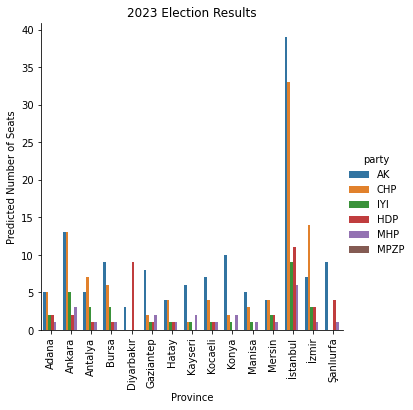

In [39]:
# Plot the predicted number of seats for each party in each province
sns.catplot(x='province', y='predicted_2023_seats', hue='party', data=predicted[predicted["province"].isin(big_cities)], kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Province')
plt.ylabel('Predicted Number of Seats')
plt.title('2023 Election Results')
plt.show()

In [40]:
'''import urllib.request

url = "https://biogeo.ucdavis.edu/data/diva/adm/TUR_adm.zip"
filename = "TUR_adm.zip"
urllib.request.urlretrieve(url, filename)

import zipfile

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()'''



'import urllib.request\n\nurl = "https://biogeo.ucdavis.edu/data/diva/adm/TUR_adm.zip"\nfilename = "TUR_adm.zip"\nurllib.request.urlretrieve(url, filename)\n\nimport zipfile\n\nwith zipfile.ZipFile(filename, \'r\') as zip_ref:\n    zip_ref.extractall()'

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Load the shapefile for Turkish provinces
map_df = gpd.read_file("TUR_adm1.shp")

map_df["NAME_1"] = ["Çanakkale", "Çankırı","Çorum","Adana","Adıyaman","Afyonkarahisar","Ağrı","Aksaray","Amasya","Ankara",
                    "Antalya","Ardahan","Artvin","Aydın","Balıkesir","Bartın","Batman","Bayburt","Bilecik","Bingöl","Bitlis",
                    "Bolu","Burdur","Bursa","Düzce","Denizli","Diyarbakır","Edirne","Elazığ","Erzincan","Erzurum","Eskişehir",
                    "Gümüşhane","Gaziantep","Giresun","Hakkari","Hatay","Iğdır","Isparta","İstanbul","İzmir","Kahramanmaraş",
                    "Kütahya","Karabük","Karaman","Kars","Kastamonu","Kayseri","Kilis","Kırıkkale","Kırklareli","Kırşehir",
                    "Kocaeli","Konya","Malatya","Manisa","Mardin","Mersin","Muğla","Muş","Nevşehir","Niğde","Ordu","Osmaniye",
                    "Rize","Sakarya","Samsun","Şanlıurfa","Siirt","Sinop","Şırnak","Sivas","Tekirdağ","Tokat","Trabzon","Tunceli",
                    "Uşak","Van","Yalova","Yozgat","Zonguldak"
                   ]


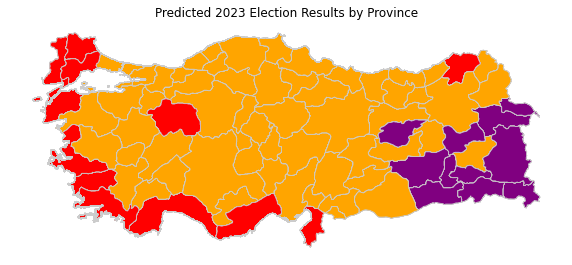

In [42]:
# Merge the election results data with the shapefile
predicted_map = map_df.merge(predicted, left_on="NAME_1", right_on="province")

# Create a new column for color
predicted_map["color"] = ""

party_colors = {
    "CHP": "purple",
    "IYI": "blue",
    "AK": "red",
    "HDP": "orange"
}

# Loop through each province
for province, group in predicted_map.groupby("province"):
    # Find the party with the highest percentage
    winning_party = group.loc[group["percentage_2023"].idxmax(), "party"]

    # Assign the color based on the winning party
    color = party_colors.get(winning_party, "black")  # Default to black if party not found

    # Update the color column for the current province
    predicted_map.loc[group.index, "color"] = color
    
# Create a custom colormap using party colors
cmap = mcolors.ListedColormap(list(party_colors.values()))

# Plot the map with colored provinces
fig, ax = plt.subplots(figsize=(10, 8))
predicted_map.plot(column="color", linewidth=0.8, edgecolor="0.8", ax=ax,cmap=cmap)

# Add title and remove axes
ax.set_title("Predicted 2023 Election Results by Province")
ax.axis("off")

# Display the plot
plt.show()


In [43]:
#predicted.to_csv("2023_election_seat_prediction_FundamentalModel.csv")